# Problem Description

You are part of Quantium’s retail analytics team and have been approached by your client, the Category Manager for Chips, who wants to better understand the types of customers who purchase Chips and their purchasing behaviour within the region.
The insights from your analysis will feed into the supermarket’s strategic plan for the chip category in the next half year.

# Imports

In [42]:
import pandas as pd
import numpy as np
import seaborn as srn
import matplotlib.pyplot as plt
import statistics as sts
import re
from collections import Counter
import scipy.stats as stats

# Loading Data

In [2]:
df_purchase = pd.read_csv('QVI_purchase_behaviour.csv')
df_transaction = pd.read_csv('QVI_transaction_data.csv')
df_transaction.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


# Exploratory Data Analysis

### Examining transaction data

In [3]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


### We can see that the 'DATE' column is in an integer format. Let's change this to a date format.

In [4]:
df_transaction['DATE'] = pd.to_datetime(df_transaction['DATE'], origin='1899-12-30', unit='D')

In [5]:
df_transaction['DATE']

0        2018-10-17
1        2019-05-14
2        2019-05-20
3        2018-08-17
4        2018-08-18
            ...    
264831   2019-03-09
264832   2018-08-13
264833   2018-11-06
264834   2018-12-27
264835   2018-09-22
Name: DATE, Length: 264836, dtype: datetime64[ns]

In [6]:
# Get the unique product names from the 'PROD_NAME' column
unique_product_names = df_transaction['PROD_NAME'].unique()

# Split the unique product names into individual words
product_words = []
for name in unique_product_names:
    words = name.split()
    product_words.extend(words)

# Create a DataFrame with the product words
product_words_df = pd.DataFrame({'words': product_words})

# Print the product words DataFrame
print(product_words_df)

           words
0        Natural
1           Chip
2         Compny
3    SeaSalt175g
4            CCs
..           ...
584         150g
585      Doritos
586        Salsa
587         Mild
588         300g

[589 rows x 1 columns]


In [7]:
# Define a regular expression pattern to match words without digits or special characters
pattern = r'^[a-zA-Z\s]+$'

# Remove words with digits or special characters and create a list of cleaned words
cleaned_words = []
for name in unique_product_names:
    words = name.split()
    for word in words:
        if re.match(pattern, word):
            cleaned_words.append(word)

# Create a DataFrame with the cleaned words
cleaned_words_df = pd.DataFrame({'words': cleaned_words})

# Sort the distinct words by frequency of occurrence
word_counts = cleaned_words_df['words'].value_counts().reset_index()
word_counts.columns = ['words', 'frequency']
sorted_words = word_counts.sort_values('frequency', ascending=False)

# Print the sorted words DataFrame
print(sorted_words)

         words  frequency
0        Chips         21
1       Smiths         16
2      Crinkle         14
3          Cut         14
4       Kettle         13
..         ...        ...
99      Vingar          1
98         Veg          1
97       Strws          1
96       Mango          1
167  Bolognese          1

[168 rows x 2 columns]


In [8]:
# Remove salsa products from the chips category
df_transaction = df_transaction[~df_transaction['PROD_NAME'].str.contains('salsa', case=False)]

# Reset the index of the resulting DataFrame
df_transaction = df_transaction.reset_index(drop=True)

# Print the updated DataFrame
print(df_transaction)

             DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0      2018-10-17          1            1000       1         5   
1      2019-05-14          1            1307     348        66   
2      2019-05-20          1            1343     383        61   
3      2018-08-17          2            2373     974        69   
4      2018-08-18          2            2426    1038       108   
...           ...        ...             ...     ...       ...   
246737 2019-03-09        272          272319  270088        89   
246738 2018-08-13        272          272358  270154        74   
246739 2018-11-06        272          272379  270187        51   
246740 2018-12-27        272          272379  270188        42   
246741 2018-09-22        272          272380  270189        74   

                                       PROD_NAME  PROD_QTY  TOT_SALES  
0         Natural Chip        Compny SeaSalt175g         2        6.0  
1                       CCs Nacho Cheese    175g         3     

### Summarise the data to check for nulls and possible outliers

In [9]:
df_transaction.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


### Check if there are nulls

In [10]:
null_counts = pd.isnull(df_transaction).sum()
null_counts

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

### It looks like there is an outlier in the "PROD_QTY" column. Let's analyze graphically

Text(0.5, 1.0, 'PROD_QTY')

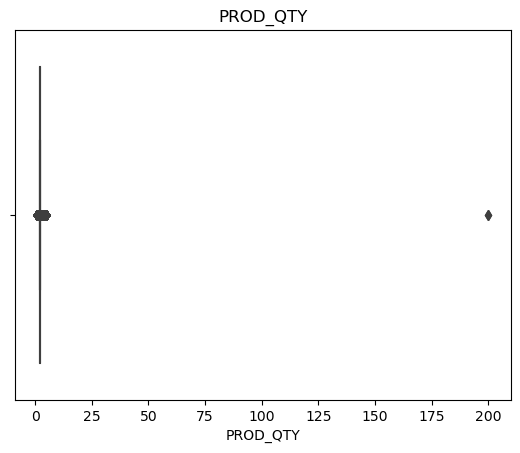

In [11]:
srn.boxplot(data=df_transaction, x='PROD_QTY').set_title("PROD_QTY")

### Let's see if the customer has had other transactions

In [12]:
df_transaction.loc[df_transaction['PROD_QTY'] > 175, 'LYLTY_CARD_NBR']

64955    226000
64956    226000
Name: LYLTY_CARD_NBR, dtype: int64

### It looks like this customer has only had the two transactions over the year and is not an ordinary retail customer. The customer might be buying chips for commercial purposes instead. We'll remove this loyalty card number from further analysis.

In [13]:
indexes_to_drop = df_transaction.loc[df_transaction['PROD_QTY'] > 175, 'LYLTY_CARD_NBR'].index
df_transaction = df_transaction.drop(indexes_to_drop)

# Double check
df_transaction.loc[df_transaction['PROD_QTY'] > 175, 'LYLTY_CARD_NBR']

Series([], Name: LYLTY_CARD_NBR, dtype: int64)

Text(0.5, 1.0, 'PROD_QTY')

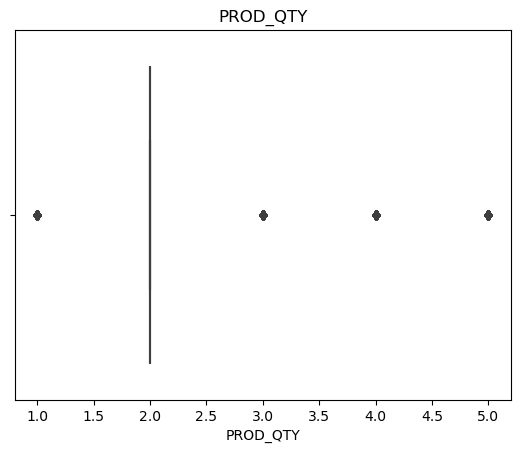

In [14]:
srn.boxplot(data=df_transaction, x='PROD_QTY').set_title("PROD_QTY")

### Now, let's look at the number of transaction lines over time to see if there are any obvious data issues such as missing data.

In [15]:
#### Count the number of transactions by date
trans_by_date = df_transaction['DATE'].value_counts()
trans_by_date = trans_by_date.sort_index()
trans_by_date

2018-07-01    663
2018-07-02    650
2018-07-03    674
2018-07-04    669
2018-07-05    660
             ... 
2019-06-26    657
2019-06-27    669
2019-06-28    673
2019-06-29    703
2019-06-30    704
Name: DATE, Length: 364, dtype: int64

### There's only 364 rows, meaning only 364 dates which indicates a missing date. Let's create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a chart of number of transactions over time to find the missing date.

(array([17713., 17775., 17836., 17897., 17956., 18017., 18078.]),
 [Text(17713.0, 0, '2018-07'),
  Text(17775.0, 0, '2018-09'),
  Text(17836.0, 0, '2018-11'),
  Text(17897.0, 0, '2019-01'),
  Text(17956.0, 0, '2019-03'),
  Text(18017.0, 0, '2019-05'),
  Text(18078.0, 0, '2019-07')])

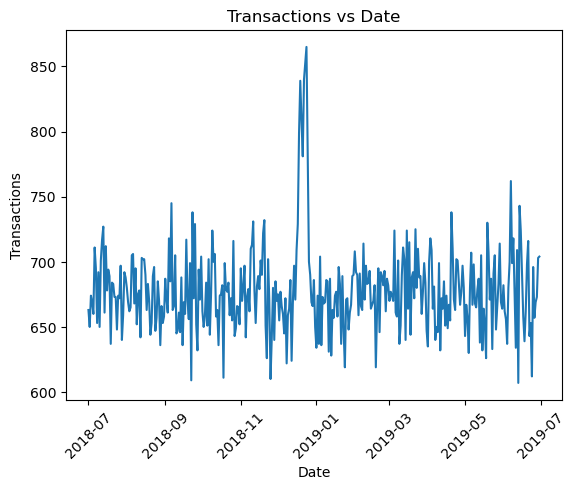

In [16]:
srn.lineplot(x=trans_by_date.index, y=trans_by_date.values)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.title('Transactions vs Date')

plt.xticks(rotation=45)

### We can see that there is an increase in purchases in December and a break in late December. Let's zoom in on this.

(array([17866., 17870., 17874., 17878., 17882., 17886., 17890., 17894.]),
 [Text(17866.0, 0, '2018-12-01'),
  Text(17870.0, 0, '2018-12-05'),
  Text(17874.0, 0, '2018-12-09'),
  Text(17878.0, 0, '2018-12-13'),
  Text(17882.0, 0, '2018-12-17'),
  Text(17886.0, 0, '2018-12-21'),
  Text(17890.0, 0, '2018-12-25'),
  Text(17894.0, 0, '2018-12-29')])

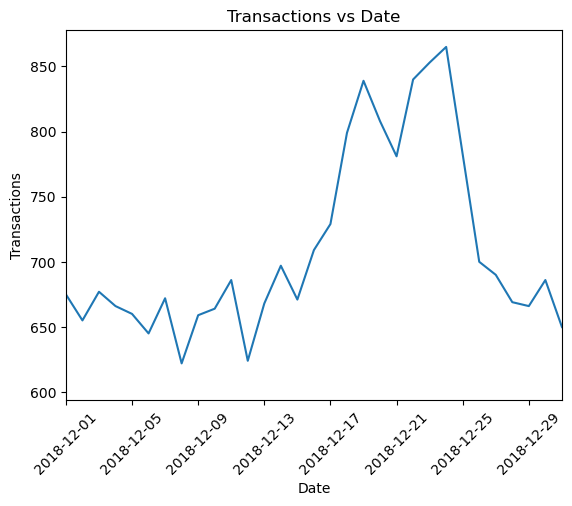

In [17]:
srn.lineplot(x=trans_by_date.index, y=trans_by_date.values)

plt.xlabel('Date')
plt.ylabel('Transactions')
plt.title('Transactions vs Date')

plt.xlim(pd.to_datetime('2018-12-01'), pd.to_datetime('2018-12-31')) 
plt.xticks(rotation=45)

(array([17866., 17870., 17874., 17878., 17882., 17886., 17890., 17894.]),
 [Text(17866.0, 0, '2018-12-01'),
  Text(17870.0, 0, '2018-12-05'),
  Text(17874.0, 0, '2018-12-09'),
  Text(17878.0, 0, '2018-12-13'),
  Text(17882.0, 0, '2018-12-17'),
  Text(17886.0, 0, '2018-12-21'),
  Text(17890.0, 0, '2018-12-25'),
  Text(17894.0, 0, '2018-12-29')])

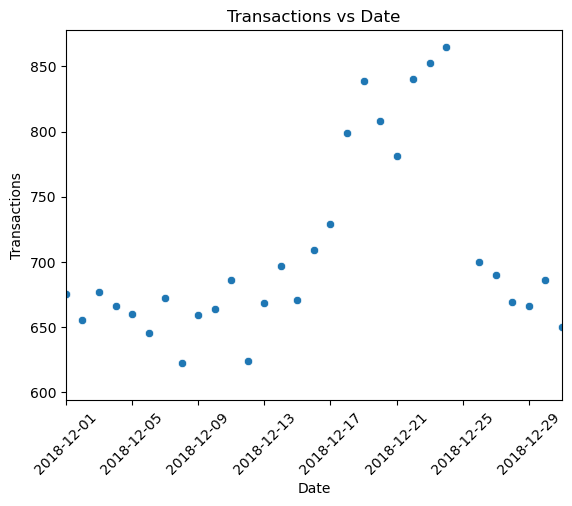

In [18]:
srn.scatterplot(x=trans_by_date.index, y=trans_by_date.values)

plt.xlabel('Date')
plt.ylabel('Transactions')
plt.title('Transactions vs Date')

plt.xlim(pd.to_datetime('2018-12-01'), pd.to_datetime('2018-12-31')) 
plt.xticks(rotation=45)

### We can see that the increase in sales occurs in the lead-up to Christmas and that there are zero sales on Christmas day itself. This is due to shops being closed on Christmas day. Check:

In [19]:
trans_by_date.loc[trans_by_date.index == pd.to_datetime('2018-12-25')]

Series([], Name: DATE, dtype: int64)

### Now, we will create a new feature based on the pack size.

In [20]:
df_transaction['PACK_SIZE'] = df_transaction['PROD_NAME'].apply(lambda x: int(''.join(re.findall(r'\d+', str(x)))))
df_transaction['PACK_SIZE']

0         175
1         175
2         170
3         175
4         150
         ... 
246737    175
246738    175
246739    170
246740    150
246741    175
Name: PACK_SIZE, Length: 246740, dtype: int64

### Let's take a look at the number of transactions as a function of packet size

Text(0, 0.5, 'Transactions')

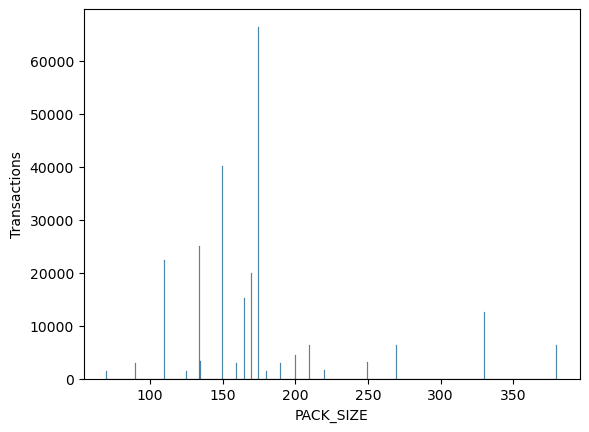

In [21]:
srn.histplot(df_transaction['PACK_SIZE'])
plt.ylabel('Transactions')

### Let's create a new feature called "BRAND"

In [22]:
df_transaction['BRAND'] = df_transaction['PROD_NAME'].str.split().str[0]

In [23]:
df_transaction['BRAND'].value_counts()

Kettle        41288
Smiths        27390
Pringles      25102
Doritos       22041
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Red            4427
Dorito         3183
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: BRAND, dtype: int64

###  We note that there are brands that, although the names are different, they are the same brand (Red = RRD = Red Rock Deli chips)

In [24]:
df_transaction['BRAND'] = df_transaction['BRAND'].replace({'Red': 'RRD'})
df_transaction['BRAND'].value_counts()

Kettle        41288
Smiths        27390
Pringles      25102
Doritos       22041
RRD           16321
Thins         14075
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Dorito         3183
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: BRAND, dtype: int64

# Exploratory Data Analysis

### Examining costumer data

In [25]:
df_purchase.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [26]:
df_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


### The "LYLTY_CARD_NBR" field is a unique identifier and therefore cannot have duplicate values. Let's check:

In [27]:
duplicates = df_purchase[df_purchase['LYLTY_CARD_NBR'].duplicated(keep=False)]
duplicates

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER


In [28]:
df_purchase['LIFESTAGE'].value_counts()

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

In [29]:
df_purchase['PREMIUM_CUSTOMER'].value_counts()

Mainstream    29245
Budget        24470
Premium       18922
Name: PREMIUM_CUSTOMER, dtype: int64

### Now, let's merge transaction data to customer data

In [30]:
df_combined = df_transaction.merge(df_purchase, how='left', on='LYLTY_CARD_NBR')
df_combined

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175,Kettle,YOUNG SINGLES/COUPLES,Premium
246736,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175,Tostitos,YOUNG SINGLES/COUPLES,Premium
246737,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170,Doritos,YOUNG SINGLES/COUPLES,Premium
246738,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150,Doritos,YOUNG SINGLES/COUPLES,Premium


In [31]:
df_combined.set_index('LYLTY_CARD_NBR', inplace=True) 

In [32]:
df_combined.sort_index(inplace = True)
df_combined.head()

,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
LYLTY_CARD_NBR,,,,,,,,,,,
1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,Grain,YOUNG FAMILIES,Budget
1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,Natural,YOUNG FAMILIES,Budget
1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WW,OLDER SINGLES/COUPLES,Mainstream


### Check if there are nulls

In [33]:
null_counts = pd.isnull(df_combined).sum()
null_counts

DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

### Let's start with calculating total sales by LIFESTAGE and PREMIUM_CUSTOMER and plotting the split by these segments to describe which customer segment contribute most to chip sales.

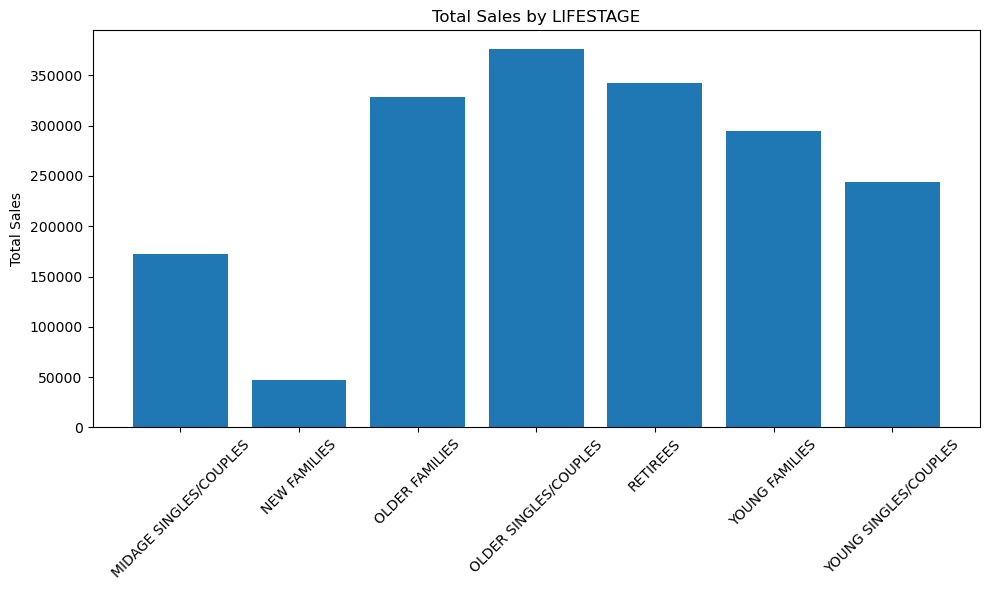

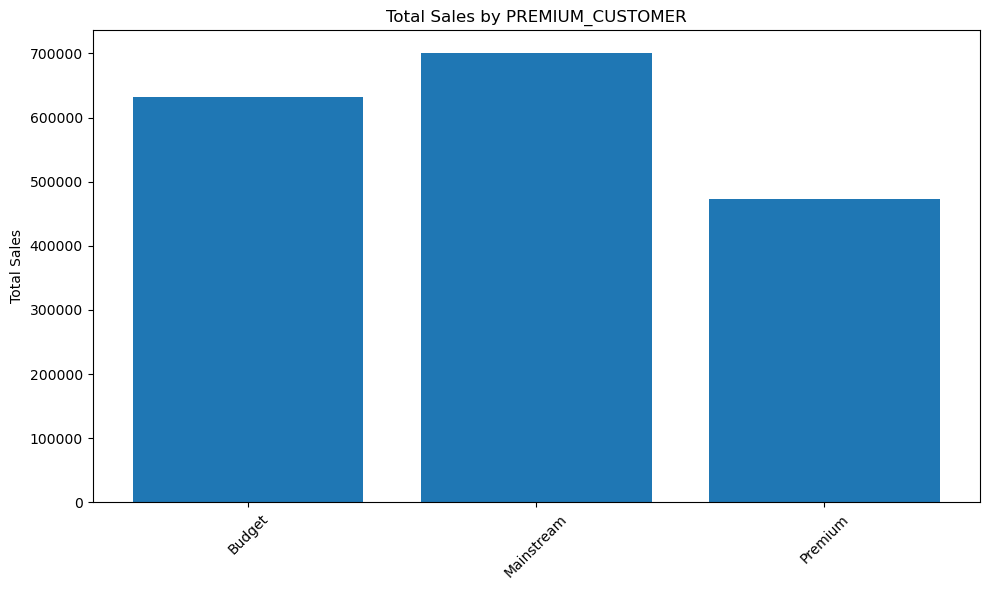

In [34]:
tot_sales_by_lifestage = df_combined.groupby('LIFESTAGE')['TOT_SALES'].sum().reset_index()
tot_sales_by_customer = df_combined.groupby('PREMIUM_CUSTOMER')['TOT_SALES'].sum().reset_index()

# Plot the total sales by lifestage
plt.figure(figsize=(10, 6))
plt.bar(tot_sales_by_lifestage['LIFESTAGE'], tot_sales_by_lifestage['TOT_SALES'])
plt.xticks(rotation=45)
plt.ylabel('Total Sales')
plt.title('Total Sales by LIFESTAGE')
plt.tight_layout()
plt.show()

# Plot the total sales by premium costumer
plt.figure(figsize=(10, 6))
plt.bar(tot_sales_by_customer['PREMIUM_CUSTOMER'], tot_sales_by_customer['TOT_SALES'])
plt.xticks(rotation=45)
plt.ylabel('Total Sales')
plt.title('Total Sales by PREMIUM_CUSTOMER')
plt.tight_layout()
plt.show()

In [35]:
sales_by_category = df_combined.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()
sales_by_category = sales_by_category.sort_values('TOT_SALES', ascending=False)
sales_by_category

,LIFESTAGE,PREMIUM_CUSTOMER,TOT_SALES
6,OLDER FAMILIES,Budget,156863.75
19,YOUNG SINGLES/COUPLES,Mainstream,147582.20
13,RETIREES,Mainstream,145168.95
15,YOUNG FAMILIES,Budget,129717.95
9,OLDER SINGLES/COUPLES,Budget,127833.60
10,OLDER SINGLES/COUPLES,Mainstream,124648.50
11,OLDER SINGLES/COUPLES,Premium,123537.55
12,RETIREES,Budget,105916.30
7,OLDER FAMILIES,Mainstream,96413.55
14,RETIREES,Premium,91296.65


### Let's see if the higher sales are due to there being more customers who buy chips.

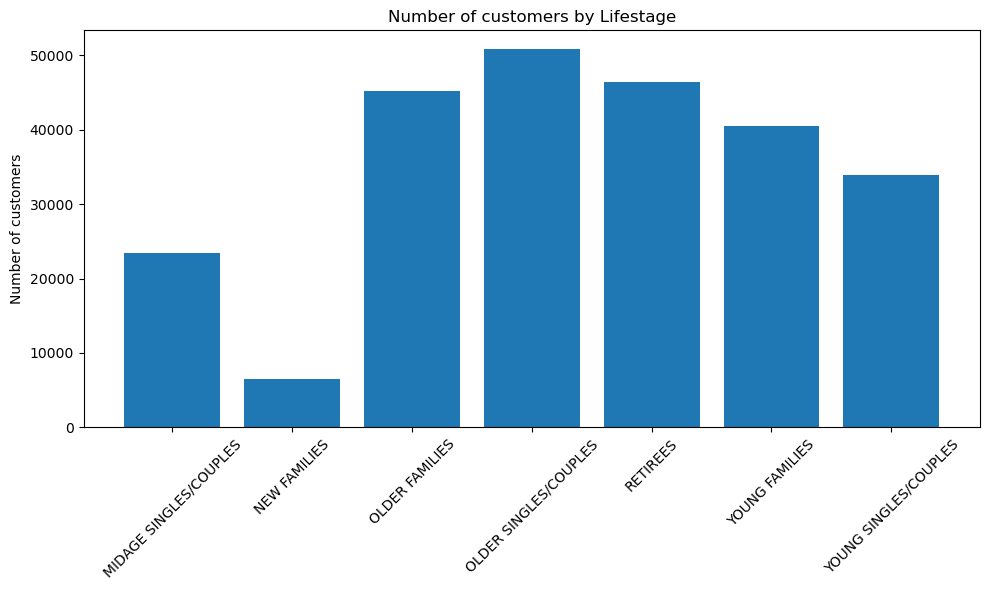

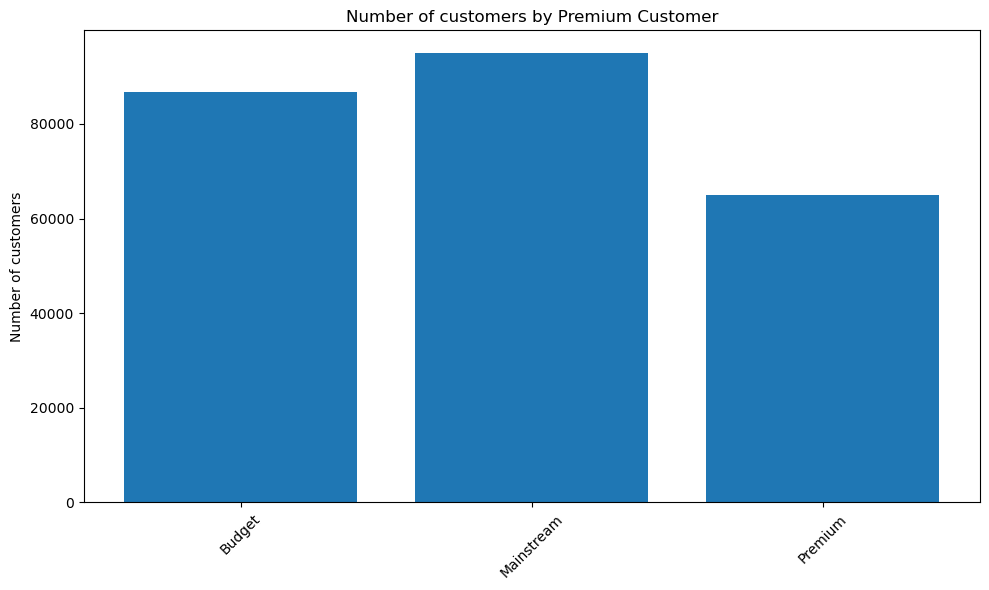

In [36]:
number_customer_by_lifestage = df_combined.groupby('LIFESTAGE').size().reset_index(name='Count')
number_customer_by_customer = df_combined.groupby('PREMIUM_CUSTOMER').size().reset_index(name='Count')

# Plot the total sales by lifestage
plt.figure(figsize=(10, 6))
plt.bar(number_customer_by_lifestage['LIFESTAGE'], number_customer_by_lifestage['Count'])
plt.xticks(rotation=45)
plt.ylabel('Number of customers')
plt.title('Number of customers by Lifestage')
plt.tight_layout()
plt.show()

# Plot the total sales by premium costumer
plt.figure(figsize=(10, 6))
plt.bar(number_customer_by_customer['PREMIUM_CUSTOMER'], number_customer_by_customer['Count'])
plt.xticks(rotation=45)
plt.ylabel('Number of customers')
plt.title('Number of customers by Premium Customer')
plt.tight_layout()
plt.show()

In [37]:
number_customer_by_category = df_combined.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).size().reset_index(name='Count')
number_customer_by_category = number_customer_by_category.sort_values('Count', ascending=False)
number_customer_by_category

,LIFESTAGE,PREMIUM_CUSTOMER,Count
6,OLDER FAMILIES,Budget,21514
13,RETIREES,Mainstream,19970
19,YOUNG SINGLES/COUPLES,Mainstream,19544
15,YOUNG FAMILIES,Budget,17763
9,OLDER SINGLES/COUPLES,Budget,17172
10,OLDER SINGLES/COUPLES,Mainstream,17061
11,OLDER SINGLES/COUPLES,Premium,16560
12,RETIREES,Budget,14225
7,OLDER FAMILIES,Mainstream,13241
14,RETIREES,Premium,12236


### Higher sales may also be driven by more units of chips being bought per customer.  Let's have a look at this next.

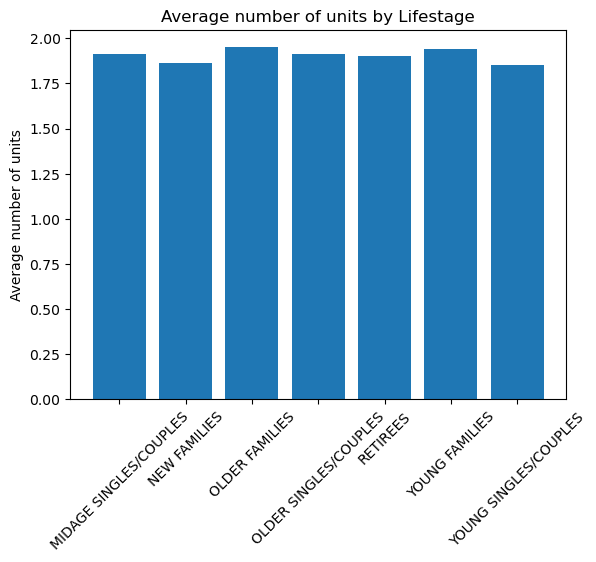

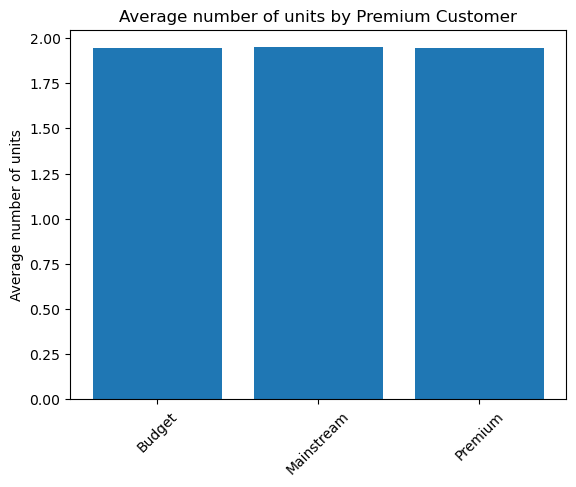

In [38]:
# Ordenating the dataframes in order to calculate the average (actually is not necessary but let's make sure)
prod_qty_by_category = df_combined.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].sum().reset_index()
prod_qty_by_category = prod_qty_by_category.sort_values(by=['LIFESTAGE', 'PREMIUM_CUSTOMER'])
number_customer_by_category = number_customer_by_category.sort_values(by=['LIFESTAGE', 'PREMIUM_CUSTOMER'])

avr_qty_per_cust = prod_qty_by_category['PROD_QTY'] / number_customer_by_category['Count']

# Average number of units per customer by LIFESTAGE

plt.bar(number_customer_by_category['LIFESTAGE'], avr_qty_per_cust.values)
plt.ylabel('Average number of units')
plt.xticks(rotation=45)
plt.title('Average number of units by Lifestage')

plt.show()

# Average number of units per customer by PREMIUM_CUSTOMER

plt.bar(number_customer_by_category['PREMIUM_CUSTOMER'], avr_qty_per_cust.values)
plt.ylabel('Average number of units')
plt.xticks(rotation=45)
plt.title('Average number of units by Premium Customer')

plt.show()

In [39]:
avr_qty_by_category = prod_qty_by_category[['LIFESTAGE', 'PREMIUM_CUSTOMER']].copy()
avr_qty_by_category['AVR_QTY_PER_CUST'] = prod_qty_by_category['PROD_QTY'] / number_customer_by_category['Count']
avr_qty_by_category = avr_qty_by_category.sort_values('AVR_QTY_PER_CUST', ascending=False)
avr_qty_by_category

,LIFESTAGE,PREMIUM_CUSTOMER,AVR_QTY_PER_CUST
7,OLDER FAMILIES,Mainstream,1.948795
8,OLDER FAMILIES,Premium,1.945496
6,OLDER FAMILIES,Budget,1.945384
16,YOUNG FAMILIES,Mainstream,1.941408
15,YOUNG FAMILIES,Budget,1.941226
17,YOUNG FAMILIES,Premium,1.938149
9,OLDER SINGLES/COUPLES,Budget,1.914920
11,OLDER SINGLES/COUPLES,Premium,1.913949
1,MIDAGE SINGLES/COUPLES,Mainstream,1.911942
10,OLDER SINGLES/COUPLES,Mainstream,1.911201


### Older families and young families in general buy more chips per customer.

### Furthermore, it is crucial to delve into the average price per unit of chips purchased within each customer segment, as this factor significantly influences the overall sales performance.

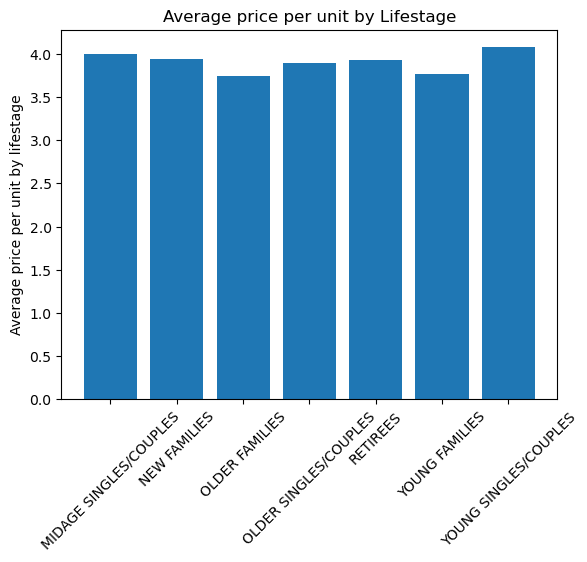

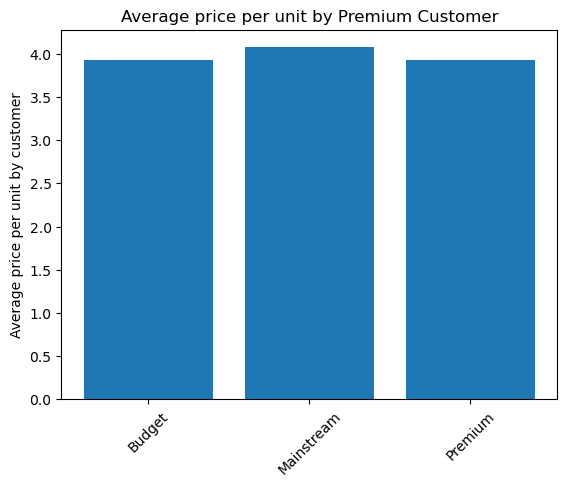

In [40]:
avg_price_per_unit = sales_by_category['TOT_SALES'] / prod_qty_by_category['PROD_QTY']

plt.bar(number_customer_by_category['LIFESTAGE'], avg_price_per_unit.values)
plt.ylabel('Average price per unit by lifestage')
plt.xticks(rotation=45)
plt.title('Average price per unit by Lifestage')

plt.show()

plt.bar(number_customer_by_category['PREMIUM_CUSTOMER'], avg_price_per_unit.values)
plt.ylabel('Average price per unit by customer')
plt.xticks(rotation=45)
plt.title('Average price per unit by Premium Customer')

plt.show()

In [41]:
avg_price_by_category = prod_qty_by_category[['LIFESTAGE', 'PREMIUM_CUSTOMER']].copy()
avg_price_by_category['AVG_PRICE_PER_UNIT'] = sales_by_category['TOT_SALES'] / prod_qty_by_category['PROD_QTY']
avg_price_by_category = avg_price_by_category.sort_values('AVG_PRICE_PER_UNIT', ascending=False)
avg_price_by_category

,LIFESTAGE,PREMIUM_CUSTOMER,AVG_PRICE_PER_UNIT
19,YOUNG SINGLES/COUPLES,Mainstream,4.074043
1,MIDAGE SINGLES/COUPLES,Mainstream,3.994449
4,NEW FAMILIES,Mainstream,3.935887
12,RETIREES,Budget,3.932731
3,NEW FAMILIES,Budget,3.931969
14,RETIREES,Premium,3.924037
11,OLDER SINGLES/COUPLES,Premium,3.897698
9,OLDER SINGLES/COUPLES,Budget,3.887529
5,NEW FAMILIES,Premium,3.886168
13,RETIREES,Mainstream,3.852986
